In [ ]:
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add, Input
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils.np_utils import to_categorical 
from keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 
import os 

In [3]:
!pip3 install tensorflow pandas

     |██████▊                         | 103.8 MB 3.3 MB/s eta 0:02:00^C |▏                               | 2.0 MB 295 kB/s eta 0:27:57     |██                              | 31.7 MB 2.7 MB/s eta 0:02:51     |██                              | 32.0 MB 2.7 MB/s eta 0:02:51     |██▍                             | 36.9 MB 4.6 MB/s eta 0:01:41     |███▏                            | 50.0 MB 2.1 MB/s eta 0:03:35     |████                            | 63.7 MB 3.7 MB/s eta 0:01:59     |████▍                           | 69.1 MB 4.8 MB/s eta 0:01:31     |█████▉                          | 91.1 MB 6.0 MB/s eta 0:01:08     |██████                          | 91.8 MB 2.7 MB/s eta 0:02:32     |██████▌                         | 100.3 MB 3.3 MB/s eta 0:02:01     |██████▌                         | 100.9 MB 3.3 MB/s eta 0:02:00

ERROR: Operation cancelled by user


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255. 
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255. 
y_train = y_train.astype('int') 
y_test = y_test.astype('int') 
# print('Training', x_train.shape, x_train.max()) 
# print('Testing', x_test.shape, x_test.max()) 

In [ ]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
# print('train groups:', [x.shape[0] for x in train_groups])
# print('test groups:', [x.shape[0] for x in test_groups])

In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      # anything but the same group
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize
    out_img_b += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
  return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

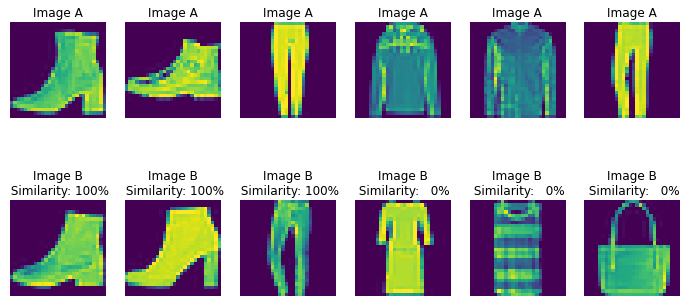

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [ ]:
################################################################################

class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
        
        channel = channel_out // 4
        
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
           
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(32)
            # Dense(1000, activation = tf.nn.relu),
            #Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
    
model = ResNet50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

################################################################################

Model: "res_net50_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         multiple                  3200      
                                                                 
 batch_normalization_104 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 activation_104 (Activation)  multiple                 0         
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 residual_block_32 (Residual  multiple                 75904     
 Block)                                                          
                                                       

In [ ]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name =
'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 res_net50_2 (ResNet50)         (None, 32)           24319776    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['res_net50_2[0][0

In [ ]:
# setup the optimization process
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
similarity_model.compile(optimizer=opt, loss = 'binary_crossentropy',
metrics = ['mae'])

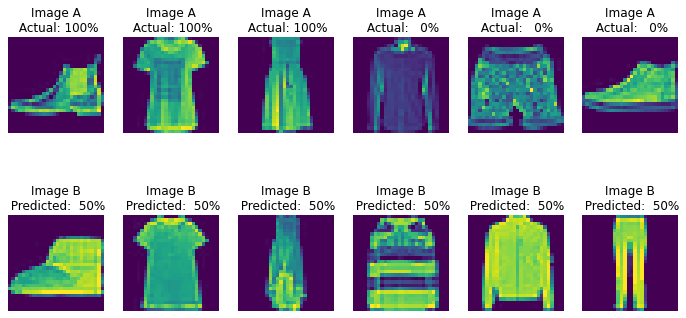

In [ ]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  return fig
  
# a completely untrained model
_ = show_model_output()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=0, min_lr=0.0001, verbose=1)

In [ ]:
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)


loss_history = similarity_model.fit(siam_gen(train_groups), 
                                    steps_per_epoch = 500,
                                    validation_data=([valid_a, valid_b],
                                                     valid_sim), 
                                    callbacks=[early_stopping, reduce_lr],
                                    epochs=10,
                                    verbose=True)

Epoch 1/10
500/500 [==============================] - 108s 193ms/step - loss: 0.5144 - mae: 0.3542 - val_loss: 0.4084 - val_mae: 0.2494 - lr: 0.0100
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.4106 - mae: 0.2673
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
500/500 [==============================] - 92s 184ms/step - loss: 0.4106 - mae: 0.2673 - val_loss: 0.4795 - val_mae: 0.2926 - lr: 0.0100
Epoch 3/10
500/500 [==============================] - 95s 189ms/step - loss: 0.3673 - mae: 0.2402 - val_loss: 0.3427 - val_mae: 0.2282 - lr: 0.0020
Epoch 4/10
500/500 [==============================] - 92s 183ms/step - loss: 0.3571 - mae: 0.2293 - val_loss: 0.3325 - val_mae: 0.2150 - lr: 0.0020
Epoch 5/10
500/500 [==============================] - 91s 182ms/step - loss: 0.3409 - mae: 0.2177 - val_loss: 0.3284 - val_mae: 0.2057 - lr: 0.0020
Epoch 6/10
500/500 [==============================] - 91s 182ms/step - loss: 0.3356 - mae: 0.2141 - val

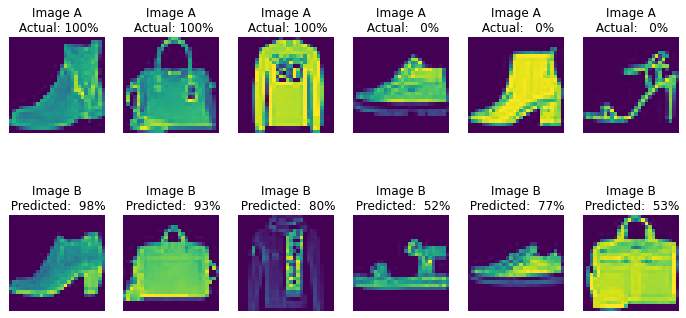

In [ ]:
_ = show_model_output()

In [ ]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose =
True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose
= True, batch_size = 128)

79/79 [==============================] - 5s 67ms/step


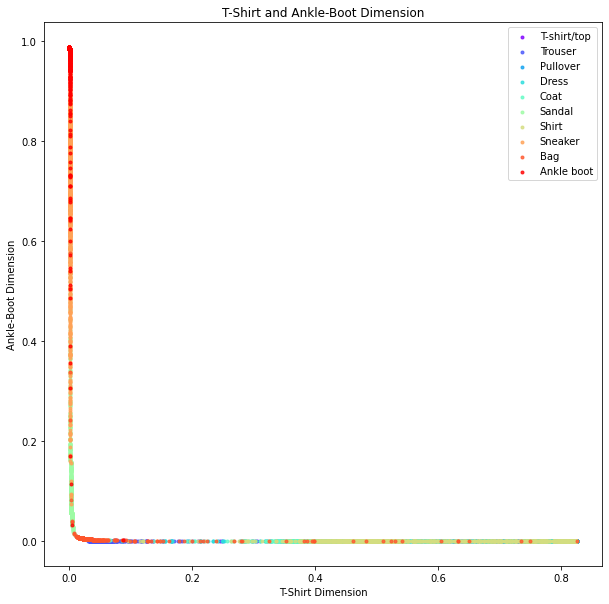

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                  ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
              ankle_boot_score[np.where(y_test == c_group), 0],
              marker='.',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [ ]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

79/79 [==============================] - 4s 32ms/step


In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=1000,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 2.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 284.050145
[t-SNE] Computed conditional probabilities in 0.748s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 49.3210602, gradient norm = 0.0008601 (50 iterations in 18.576s)
[t-SNE] Iteration 100: error = 49.0792465, gradient norm = 0.0007518 (50 iterations in 17.918s)
[t-SNE] Iteration 150: error = 49.6264267, gradient norm = 0.0007534 (50 iterations in 18.219s)
[t-SNE] Iteration 200: error = 51.0030556, gradient norm = 0.0007764 (50 iterations in 18.369s)
[t-SNE] Iteration 250: error = 53.6638412, gradient norm = 0.0008287 (50 iterations in 17.507s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.663841
[t-SNE] Iteration 300: error = 1.7980200, gradient norm = 0.0007010 (50 iterations in 17.994s)
[t-SNE] Iteration 350: error = 1.5945698, gradient norm = 0.0003921 (50 iterations in 17.963s)
[t-SNE] Iteration 400: error = 1.4708815, gradient norm = 0.0002534 (50 iterations in 17.384s)
[t-SNE] Iteration 450: error = 1.3919538, gradient norm = 0.0001804 (50 iterations in 17.575s)
[t-SNE] Iteration 500: error = 1.3376532, gradient norm = 0.000

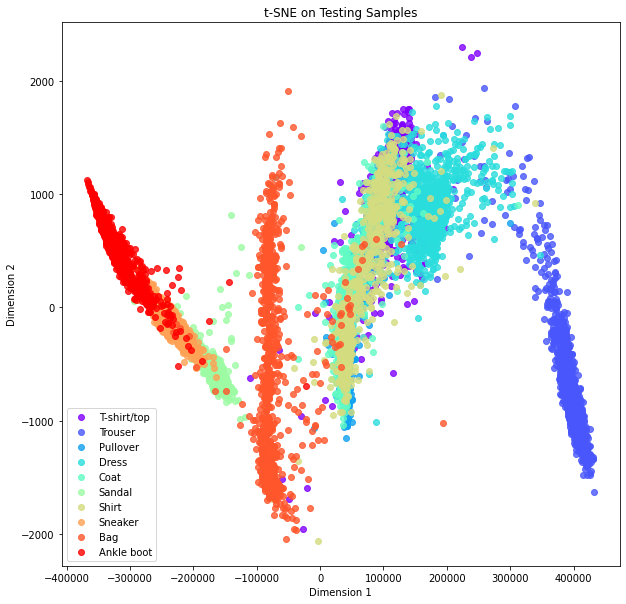

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                  ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0],
              tsne_features[np.where(y_test == c_group), 1],
              marker='o',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)